In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyfixest as pf
from chump import Application

In [2]:
buzzer_auth = json.load(open("/root/notebooks/pushover_auth.txt"))
user = Application(buzzer_auth["key"]).get_user(buzzer_auth["user"])
user.is_authenticated, user.devices

user.send_message("started running")

## DGP

In [3]:
def generate_treatment_effect(effect_type, T, T0, max_effect=1):
    if effect_type == "constant":
        return np.concatenate([np.zeros(T0), np.full(T - T0, max_effect)])
    elif effect_type == "linear":
        return np.concatenate([np.zeros(T0), np.linspace(0, max_effect, T - T0)])
    elif effect_type == "concave":
        return np.concatenate(
            [
                np.zeros(T0),
                max_effect * 0.5 * np.log(2 * np.arange(1, T - T0 + 1) / (T - T0) + 1),
            ]
        )
    elif effect_type == "positive_then_negative":
        half_point = (T - T0) // 2
        return np.concatenate(
            [
                np.zeros(T0),
                np.linspace(0, max_effect, half_point),
                np.linspace(max_effect, -max_effect, T - T0 - half_point),
            ]
        )
    elif effect_type == "exponential":
        return np.concatenate(
            [
                np.zeros(T0),
                max_effect * (1 - np.exp(-np.linspace(0, 5, T - T0))),
            ]
        )
    elif effect_type == "sinusoidal":
        return np.concatenate(
            [
                np.zeros(T0),
                max_effect * np.sin(np.linspace(0, 2 * np.pi, T - T0)),
            ]
        )
    elif effect_type == "random_walk":
        return np.concatenate(
            [
                np.zeros(T0),
                max_effect * np.cumsum(np.random.randn(T - T0)),
            ]
        )
    else:
        raise ValueError("Unknown effect type")

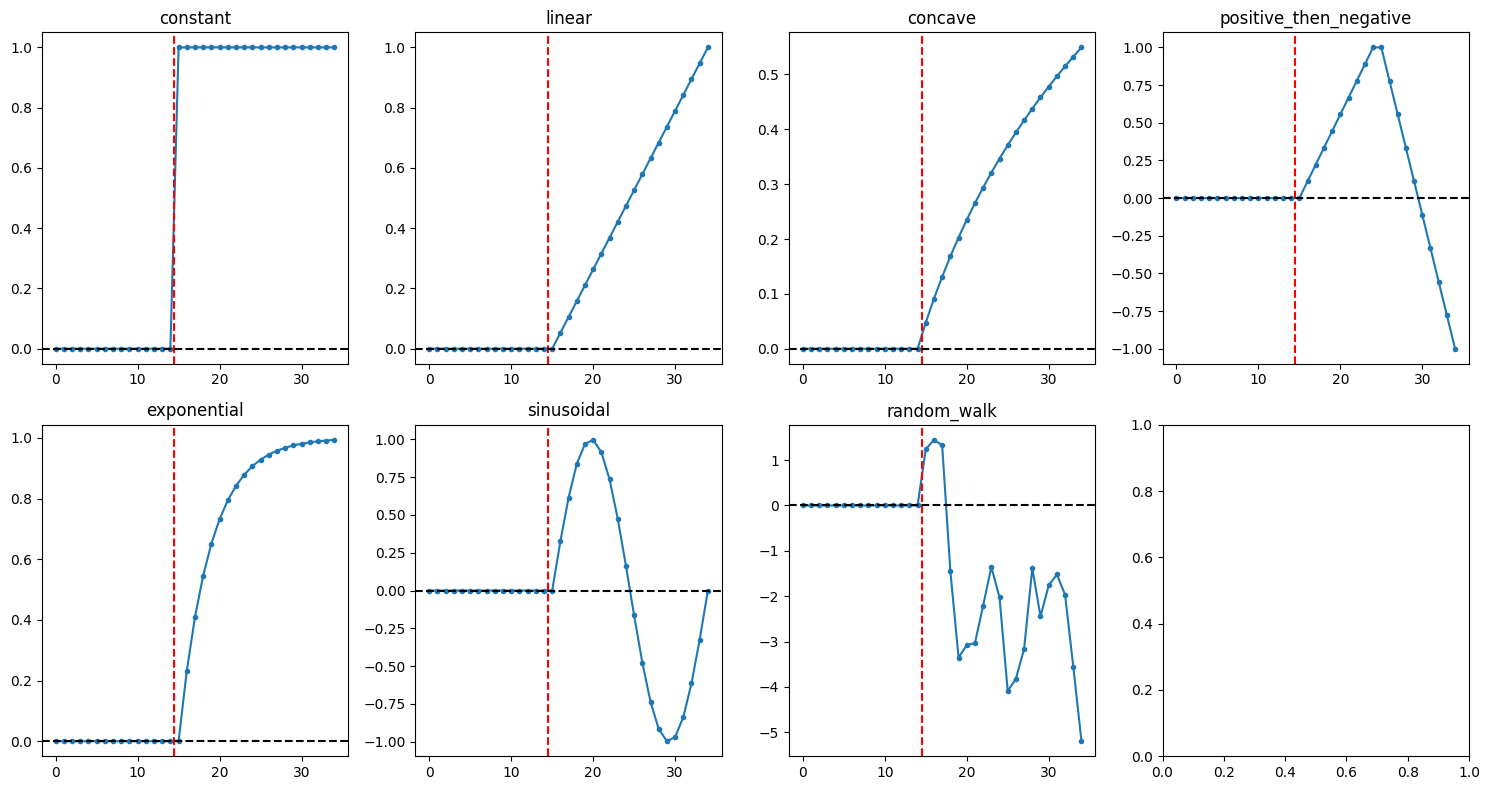

In [4]:
# Plotting the treatment effects
effect_types = [
    "constant",
    "linear",
    "concave",
    "positive_then_negative",
    "exponential",
    "sinusoidal",
    "random_walk",
]
T, T0 = 35, 15
max_effect = 1

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i, effect_type in enumerate(effect_types):
    ax = axes[i // 4, i % 4]
    ax.plot(generate_treatment_effect(effect_type, T, T0, max_effect), marker=".")
    ax.set_title(effect_type)
    ax.axvline(T0 - 0.5, color="red", linestyle="--")
    ax.axhline(0, color="black", linestyle="--")

plt.tight_layout()

In [5]:
def sim_panel_advanced(
    base_effect,
    N=1_000_000,
    T=35,
    T0=15,
    sigma_list=[5, 2, 0.01, 2],
    hetfx=False,
    num_treated=None,
    rho=0.7,
    seed=42,
    debug=False,
):
    np.random.seed(seed)
    sigma_unit, sigma_time, sigma_tt, sigma_e = sigma_list
    # Generate data
    unit_ids = np.repeat(np.arange(N), T)
    time_ids = np.tile(np.arange(T), N)
    # Generate unit-specific intercepts and time trends
    unit_fe = np.random.normal(0, sigma_unit, N)
    time_fe = np.random.normal(0, sigma_time, T)
    unit_tt = np.random.normal(0, sigma_tt, N)
    # Generate treatment indicator
    if num_treated is None:
        W = np.random.binomial(1, 0.5, N)
    else:
        treated_units = np.random.choice(N, num_treated, replace=False)
        W = np.zeros(N)
        W[treated_units] = 1
    W = np.repeat(W, T)
    W = W * (time_ids >= T0)
    # Generate treatment effect
    if hetfx:
        unit_effects = np.random.uniform(0.5, 1.5, N)
    else:
        unit_effects = np.ones(N)
    treatment_effect = np.outer(unit_effects, base_effect)
    # Generate serially correlated residuals
    residuals = np.zeros((N, T))
    residuals[:, 0] = np.random.normal(0, sigma_e, N)
    epsilon = np.random.normal(0, 1, (N, T - 1))
    factor = sigma_e * np.sqrt(1 - rho**2)
    for t in range(1, T):
        residuals[:, t] = rho * residuals[:, t - 1] + factor * epsilon[:, t - 1]
    # Generate outcome
    Y = (
        np.repeat(unit_fe, T)
        + np.repeat(unit_tt, T) * time_ids
        + treatment_effect.flatten() * W
        + np.tile(time_fe, N)
        + residuals.flatten()
    )

    # Create DataFrame
    df = pd.DataFrame({"unit": unit_ids, "time": time_ids, "Y": Y, "W": W})
    if debug:
        return Y, W, treatment_effect, df
    return df

### estimators

In [6]:
def diff_in_means(df, T, T0):
    cross_sec_df = (
        df.query(f"time >= {T0}").groupby("unit").agg({"Y": "mean", "W": "max"})
    )
    estimate = pf.feols("Y~W", cross_sec_df).tidy().loc["W", "Estimate"]
    return np.repeat(estimate, T - T0)


def cuped(df, T, T0):
    cross_sec_df = (
        df.query(f"time >= {T0}").groupby("unit").agg({"Y": "mean", "W": "max"})
    )
    cross_sec_df = cross_sec_df.merge(
        df.query(f"time < {T0}").groupby("unit").Y.mean().rename("ldv"),
        left_index=True,
        right_index=True,
    )
    estimate = pf.feols("Y~W+ldv", cross_sec_df).tidy().loc["W", "Estimate"]
    return np.repeat(estimate, T - T0)


def twfe(df, T, T0):
    m = pf.feols("Y~W | unit + time", df).tidy()
    estimate = m.loc["W", "Estimate"]
    return np.repeat(estimate, T - T0)


def panel_diff_in_means(df, T, T0):
    mean_outcomes = df.groupby(["W", "time"])["Y"].mean().unstack()
    diff_means = mean_outcomes.iloc[1, :] - mean_outcomes.iloc[0, :]
    return diff_means[diff_means.notna()].values


def event_study(df, T, T0):
    df["ever_treated"] = df.groupby("unit")["W"].transform("max")
    m = pf.feols(f"Y ~ i(time, ever_treated, ref = {T0-1}) | unit + time", df)
    return m.coef()[(T0 - 1) :].values

## simulations

In [7]:
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error

In [8]:
# Define the simulation engine
def simulation_engine(
    effect_type, T, T0, max_effect, N, num_treated, sigma_list, hetfx, rho, seed
):
    # Generate true treatment effects
    effect_vector = generate_treatment_effect(effect_type, T, T0, max_effect)
    # Simulate data
    df = sim_panel_advanced(
        effect_vector,
        N=N,
        T=T,
        T0=T0,
        sigma_list=sigma_list,
        hetfx=hetfx,
        num_treated=num_treated,
        rho=rho,
        seed=seed,
    )
    # Apply estimators
    estimates = {}
    estimates["true_effect"] = effect_vector[T0:]
    estimators = [diff_in_means, cuped, twfe, panel_diff_in_means, event_study]
    # apply them and add to the estimates dictionary
    for estimator in estimators:
        estimates[estimator.__name__] = estimator(df, T, T0)
    return estimates

#### warmup for demo figure

In [9]:
effect_types = [
    "constant",
    "linear",
    "concave",
    "positive_then_negative",
    "exponential",
    "sinusoidal",
    "random_walk",
]
T, T0 = 35, 15
max_effect = 1
ests = {}
for effect_type in effect_types:
    est = simulation_engine(
        effect_type, T, T0, max_effect, 100_000, 50_000, [5, 2, 0.01, 2], False, 0.7, 42
    )
    ests[effect_type] = pd.DataFrame.from_dict(est)

Text(0.5, 0.98, 'Estimation Accuracy for different heterogeneity types')

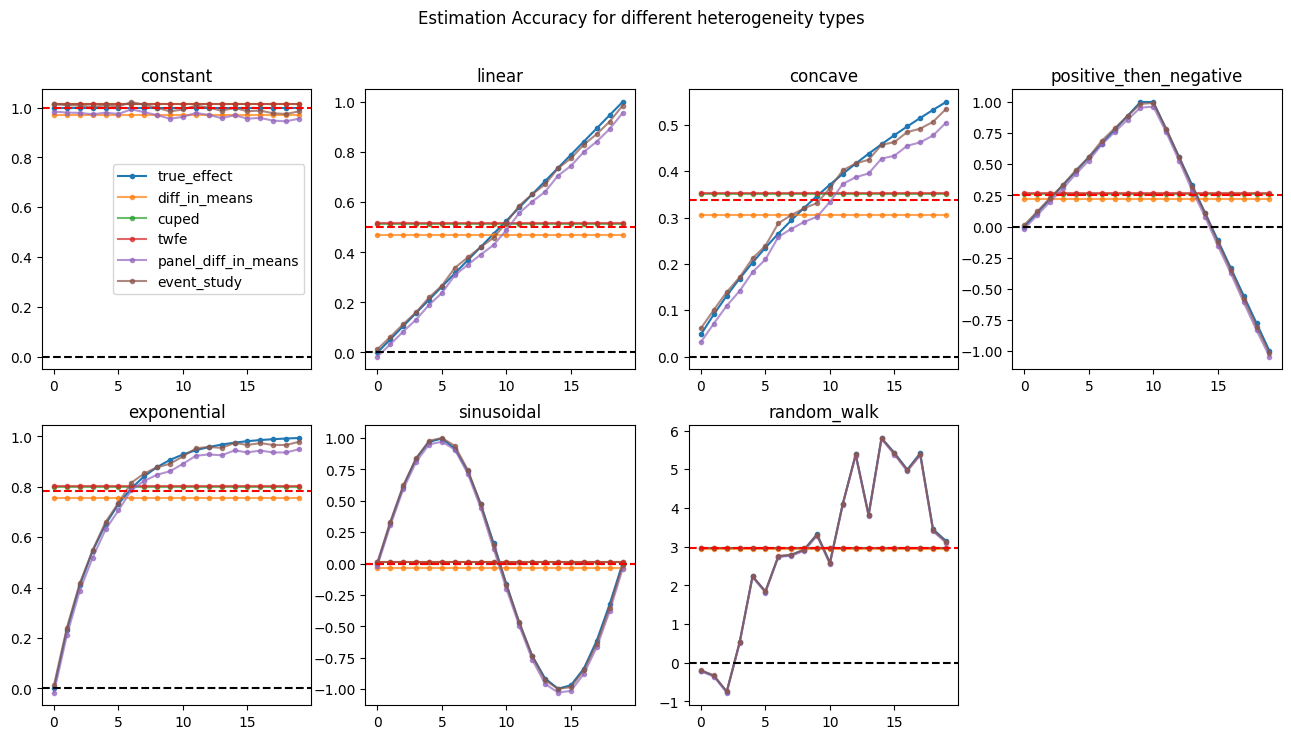

In [10]:
f, ax = plt.subplots(2, 4, figsize=(16, 8))
for k, v, i in zip(ests.keys(), ests.values(), range(7)):
    v[["true_effect"]].plot(
        ax=ax[i // 4, i % 4], marker=".", ms=6, alpha=1, legend=False
    )
    v.drop(["true_effect"], axis=1).plot(
        ax=ax[i // 4, i % 4], marker=".", alpha=0.7, legend=False
    )
    ax[i // 4, i % 4].set_title(k)
    ax[i // 4, i % 4].axhline(0, color="black", linestyle="--")
    ax[i // 4, i % 4].axhline(v.true_effect.mean(), color="red", linestyle="--")
ax[0, 0].legend()
# destroy empty axis
ax[1, 3].axis("off")
f.suptitle("Estimation Accuracy for different heterogeneity types")

### repeat

In [11]:
from multiprocessing import cpu_count
import pickle
cpu_count()

96

In [13]:
def evaluate_estimators(
    n_simulations,
    effect_type,
    T,
    T0,
    max_effect,
    N,
    num_treated,
    sigma_list,
    hetfx,
    rho,
    njobs=-1,
):
    results = Parallel(n_jobs=njobs)(
        delayed(simulation_engine)(
            effect_type, T, T0, max_effect, N, num_treated, sigma_list, hetfx, rho, seed
        )
        for seed in range(n_simulations)
    )
    # pickle output
    fn = f"raw_sim_out/{n_simulations}_{effect_type}_{T}_{T0}_{max_effect}_{N}_{num_treated}_{sigma_list}_{hetfx}_{rho}.pkl"
    with open(fn, "wb") as f:
        pickle.dump(results, f)

    biases = {key: [] for key in results[0].keys() if key != "true_effect"}
    variances = {key: [] for key in results[0].keys() if key != "true_effect"}
    rmses = {key: [] for key in results[0].keys() if key != "true_effect"}

    for estimates in results:
        true_effect = estimates["true_effect"]
        for key, estimate in estimates.items():
            if key == "true_effect":
                continue
            bias = np.mean(estimate - true_effect)
            variance = np.var(estimate)
            rmse = np.sqrt(mean_squared_error(true_effect, estimate))
            biases[key].append(bias)
            variances[key].append(variance)
            rmses[key].append(rmse)

    # Aggregate results
    bias_means = {key: np.mean(val) for key, val in biases.items()}
    variance_means = {key: np.mean(val) for key, val in variances.items()}
    rmse_means = {key: np.mean(val) for key, val in rmses.items()}

    return bias_means, variance_means, rmse_means

### Numerical Experiments 

Takes ~1.2 hours on a 96-core instance with 1TB of RAM. Will take quite a lot longer on a personal machine; consider lowering the number of replications / sample size / parallelism for tractability. 

### weak TT

In [13]:
# Define the simulation parameters
n_simulations = 1000
T, T0 = 35, 15
max_effect = 1
N = 100_000
num_treated = 50_000
sigma_list = [5, 2, 0.01, 2]
rho = 0.7

# Define the heterogeneity configurations
heterogeneity_configs = [
    ("constant", False),
    ("linear", False),
    ("concave", False),
    ("positive_then_negative", False),
    ("exponential", False),
    ("sinusoidal", False),
    ("random_walk", False),
    ("constant", True),
    ("linear", True),
    ("concave", True),
    ("positive_then_negative", True),
    ("exponential", True),
    ("sinusoidal", True),
    ("random_walk", True),
]

# Create a list to store the results
results = []

# Loop over the heterogeneity configurations
for effect_type, hetfx in heterogeneity_configs:
    print(f"Running simulations for {effect_type} with heterogeneity={hetfx}")
    bias_means, variance_means, rmse_means = evaluate_estimators(
        n_simulations,
        effect_type,
        T,
        T0,
        max_effect,
        N,
        num_treated,
        sigma_list,
        hetfx,
        rho,
        njobs=cpu_count(), # runs on all cores by default - change if needed
    )
    # send a notification
    user.send_message(
        f"Finished simulations for {effect_type} with heterogeneity={hetfx}"
    )
    # Append the results to the list
    for estimator, bias in bias_means.items():
        variance = variance_means[estimator]
        rmse = rmse_means[estimator]
        results.append(
            {
                "Effect Type": effect_type,
                "Heterogeneity": hetfx,
                "Estimator": estimator,
                "Bias": bias,
                "Variance": variance,
                "RMSE": rmse,
            }
        )

results_df = pd.DataFrame(results)
user.send_message("finished running")

Running simulations for constant with heterogeneity=False


Running simulations for linear with heterogeneity=False
Running simulations for concave with heterogeneity=False
Running simulations for positive_then_negative with heterogeneity=False
Running simulations for exponential with heterogeneity=False
Running simulations for sinusoidal with heterogeneity=False
Running simulations for random_walk with heterogeneity=False
Running simulations for constant with heterogeneity=True
Running simulations for linear with heterogeneity=True
Running simulations for concave with heterogeneity=True
Running simulations for positive_then_negative with heterogeneity=True
Running simulations for exponential with heterogeneity=True
Running simulations for sinusoidal with heterogeneity=True
Running simulations for random_walk with heterogeneity=True
    Effect Type  Heterogeneity            Estimator      Bias      Variance  \
0      constant          False        diff_in_means -0.000536  3.779137e-32   
1      constant          False                cuped -0.00

In [ ]:
results_df.to_csv("sim_output_weak_tt.csv")

In [19]:
results_df = pd.read_csv("sim_output_weak_tt.csv")
results_df = results_df[['Effect Type', 'Heterogeneity', 'Estimator', 'RMSE']].rename(
  {
    "Effect Type": "Temporal Heterogeneity",
    "Heterogeneity": "Unit Heterogeneity",
  }, axis=1
)

outtab = (
    results_df.pivot_table(
        index=["Temporal Heterogeneity", "Unit Heterogeneity"],
        columns="Estimator",
        values="RMSE",
    )
    .rename(
        columns={
            "cuped": "CUPED (XC)",
            "diff_in_means": " Diff in Means (XC)",
            "twfe": "TWFE (XC)",
            "event_study": "Event Study (Dyn)",
            "panel_diff_in_means": "Diff in Means (Dyn)",
        }
    )[
        [
            " Diff in Means (XC)",
            "CUPED (XC)",
            "TWFE (XC)",
            "Diff in Means (Dyn)",
            "Event Study (Dyn)",
        ]
    ]
    .reset_index()
    .round(4)
)

outtab["Temporal Heterogeneity"] = outtab["Temporal Heterogeneity"].str.replace(
    "_", " "
)
outtab

Estimator,Temporal Heterogeneity,Unit Heterogeneity,Diff in Means (XC),CUPED (XC),TWFE (XC),Diff in Means (Dyn),Event Study (Dyn)
0,concave,False,0.1528,0.1497,0.1497,0.0291,0.0155
1,concave,True,0.1529,0.1497,0.1497,0.0292,0.0157
2,constant,False,0.0257,0.0069,0.0070,0.0291,0.0155
3,constant,True,0.0257,0.0073,0.0073,0.0292,0.0157
4,exponential,False,0.2775,0.2758,0.2758,0.0291,0.0155
5,exponential,True,0.2775,0.2758,0.2758,0.0292,0.0157
6,linear,False,0.3052,0.3036,0.3036,0.0291,0.0155
7,linear,True,0.3052,0.3036,0.3036,0.0292,0.0157
8,positive then negative,False,0.5641,0.5632,0.5632,0.0291,0.0155
9,positive then negative,True,0.5641,0.5632,0.5632,0.0292,0.0157


### strong TT

In [14]:
# Define the simulation parameters
n_simulations = 1000
T, T0 = 35, 15
max_effect = 1
N = 100_000
num_treated = 50_000
sigma_list = [5, 2, 2, 2]
rho = 0.7

# Define the heterogeneity configurations
heterogeneity_configs = [
    ("constant", False),
    ("linear", False),
    ("concave", False),
    ("positive_then_negative", False),
    ("exponential", False),
    ("sinusoidal", False),
    ("random_walk", False),
    ("constant", True),
    ("linear", True),
    ("concave", True),
    ("positive_then_negative", True),
    ("exponential", True),
    ("sinusoidal", True),
    ("random_walk", True),
]

# Create a list to store the results
results = []

# Loop over the heterogeneity configurations
for effect_type, hetfx in heterogeneity_configs:
    print(f"Running simulations for {effect_type} with heterogeneity={hetfx}")
    bias_means, variance_means, rmse_means = evaluate_estimators(
        n_simulations,
        effect_type,
        T,
        T0,
        max_effect,
        N,
        num_treated,
        sigma_list,
        hetfx,
        rho,
        njobs=cpu_count(),
    )
    user.send_message(
        f"Finished simulations for {effect_type} with heterogeneity={hetfx}"
    )
    # Append the results to the list
    for estimator, bias in bias_means.items():
        variance = variance_means[estimator]
        rmse = rmse_means[estimator]
        results.append(
            {
                "Effect Type": effect_type,
                "Heterogeneity": hetfx,
                "Estimator": estimator,
                "Bias": bias,
                "Variance": variance,
                "RMSE": rmse,
            }
        )
user.send_message("finished running")

Running simulations for constant with heterogeneity=False


Running simulations for linear with heterogeneity=False
Running simulations for concave with heterogeneity=False
Running simulations for positive_then_negative with heterogeneity=False
Running simulations for exponential with heterogeneity=False
Running simulations for sinusoidal with heterogeneity=False
Running simulations for random_walk with heterogeneity=False
Running simulations for constant with heterogeneity=True
Running simulations for linear with heterogeneity=True
Running simulations for concave with heterogeneity=True
Running simulations for positive_then_negative with heterogeneity=True
Running simulations for exponential with heterogeneity=True
Running simulations for sinusoidal with heterogeneity=True
Running simulations for random_walk with heterogeneity=True


In [17]:
results_df = pd.DataFrame(results)
results_df.to_csv("sim_output_strong_tt.csv")

In [18]:
results_df = pd.read_csv("sim_output_strong_tt.csv")
results_df = results_df[['Effect Type', 'Heterogeneity', 'Estimator', 'RMSE']].rename(
  {
    "Effect Type": "Temporal Heterogeneity",
    "Heterogeneity": "Unit Heterogeneity",
  }, axis=1
)

outtab = (
    results_df.pivot_table(
        index=["Temporal Heterogeneity", "Unit Heterogeneity"],
        columns="Estimator",
        values="RMSE",
    )
    .rename(
        columns={
            "cuped": "CUPED (XC)",
            "diff_in_means": " Diff in Means (XC)",
            "twfe": "TWFE (XC)",
            "event_study": "Event Study (Dyn)",
            "panel_diff_in_means": "Diff in Means (Dyn)",
        }
    )[
        [
            " Diff in Means (XC)",
            "CUPED (XC)",
            "TWFE (XC)",
            "Diff in Means (Dyn)",
            "Event Study (Dyn)",
        ]
    ]
    .reset_index()
    .round(4)
)

outtab["Temporal Heterogeneity"] = outtab["Temporal Heterogeneity"].str.replace(
    "_", " "
)
outtab

Estimator,Temporal Heterogeneity,Unit Heterogeneity,Diff in Means (XC),CUPED (XC),TWFE (XC),Diff in Means (Dyn),Event Study (Dyn)
0,concave,False,0.2995,0.1675,0.2418,0.2476,0.1185
1,concave,True,0.2994,0.1674,0.2415,0.2474,0.1188
2,constant,False,0.2402,0.0631,0.1714,0.2476,0.1185
3,constant,True,0.2400,0.0633,0.1706,0.2474,0.1188
4,exponential,False,0.3879,0.2864,0.3406,0.2476,0.1185
5,exponential,True,0.3879,0.2863,0.3403,0.2474,0.1188
6,linear,False,0.4097,0.3133,0.3643,0.2476,0.1185
7,linear,True,0.4096,0.3132,0.3641,0.2474,0.1188
8,positive then negative,False,0.6325,0.5686,0.6007,0.2476,0.1185
9,positive then negative,True,0.6325,0.5685,0.6005,0.2474,0.1188


## stack tables

In [24]:
weak_tt = pd.read_csv("sim_output_weak_tt.csv")
strong_tt = pd.read_csv("sim_output_strong_tt.csv")

res_all = pd.concat(
  [
  weak_tt.assign(tt="Weak"),
  strong_tt.assign(tt="Strong"),
  ],
  axis=0
)
res_all.to_csv("sim_output_all.csv")

In [2]:
res_all = pd.read_csv("../tmp/sim_output_all.csv")

In [3]:
res_all = res_all[["Effect Type", "Heterogeneity", "Estimator", "RMSE", "tt"]].rename(
    {
        "Effect Type": "Temporal Heterogeneity",
        "Heterogeneity": "Unit Heterogeneity",
        "tt": "Time Trend",
    },
    axis=1,
)

outtab = (
    res_all.pivot_table(
        index=["Temporal Heterogeneity", "Unit Heterogeneity", "Time Trend"],
        columns="Estimator",
        values="RMSE",
    )
    .rename(
        columns={
            "cuped": "CUPED (XC)",
            "diff_in_means": " Diff in Means (XC)",
            "twfe": "TWFE (XC)",
            "event_study": "Event Study (Dyn)",
            "panel_diff_in_means": "Diff in Means (Dyn)",
        }
    )[
        [
            " Diff in Means (XC)",
            "CUPED (XC)",
            "TWFE (XC)",
            "Diff in Means (Dyn)",
            "Event Study (Dyn)",
        ]
    ]
    .reset_index()
    .round(4)
)
outtab

Estimator,Temporal Heterogeneity,Unit Heterogeneity,Time Trend,Diff in Means (XC),CUPED (XC),TWFE (XC),Diff in Means (Dyn),Event Study (Dyn)
0,concave,False,Strong,0.2995,0.1675,0.2418,0.2476,0.1185
1,concave,False,Weak,0.1528,0.1497,0.1497,0.0291,0.0155
2,concave,True,Strong,0.2994,0.1674,0.2415,0.2474,0.1188
3,concave,True,Weak,0.1529,0.1497,0.1497,0.0292,0.0157
4,constant,False,Strong,0.2402,0.0631,0.1714,0.2476,0.1185
5,constant,False,Weak,0.0257,0.0069,0.0070,0.0291,0.0155
6,constant,True,Strong,0.2400,0.0633,0.1706,0.2474,0.1188
7,constant,True,Weak,0.0257,0.0073,0.0073,0.0292,0.0157
8,exponential,False,Strong,0.3879,0.2864,0.3406,0.2476,0.1185
9,exponential,False,Weak,0.2775,0.2758,0.2758,0.0291,0.0155


In [6]:
import seaborn as sns

In [7]:
# Melt the DataFrame to long format for easier plotting
melted_df = outtab.melt(
    id_vars=["Temporal Heterogeneity", "Unit Heterogeneity", "Time Trend"],
    var_name="Estimator",
    value_name="RMSE",
)
melted_df

,Temporal Heterogeneity,Unit Heterogeneity,Time Trend,Estimator,RMSE
0,concave,False,Strong,Diff in Means (XC),0.2995
1,concave,False,Weak,Diff in Means (XC),0.1528
2,concave,True,Strong,Diff in Means (XC),0.2994
3,concave,True,Weak,Diff in Means (XC),0.1529
4,constant,False,Strong,Diff in Means (XC),0.2402
...,...,...,...,...,...
135,random_walk,True,Weak,Event Study (Dyn),0.0161
136,sinusoidal,False,Strong,Event Study (Dyn),0.1185
137,sinusoidal,False,Weak,Event Study (Dyn),0.0155
138,sinusoidal,True,Strong,Event Study (Dyn),0.1188


/home/alal/miniforge3/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/alal/miniforge3/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/alal/miniforge3/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/alal/miniforge3/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/alal/miniforge3/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more va

[Text(0, 0, 'concave'), Text(1, 0, 'constant'), Text(2, 0, 'exponential'), Text(3, 0, 'linear'), Text(4, 0, 'positive_then_negative'), Text(5, 0, 'random_walk'), Text(6, 0, 'sinusoidal')]
[Text(0, 0, 'concave'), Text(1, 0, 'constant'), Text(2, 0, 'exponential'), Text(3, 0, 'linear'), Text(4, 0, 'positive_then_negative'), Text(5, 0, 'random_walk'), Text(6, 0, 'sinusoidal')]


/tmp/ipykernel_762303/253779867.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
/tmp/ipykernel_762303/253779867.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


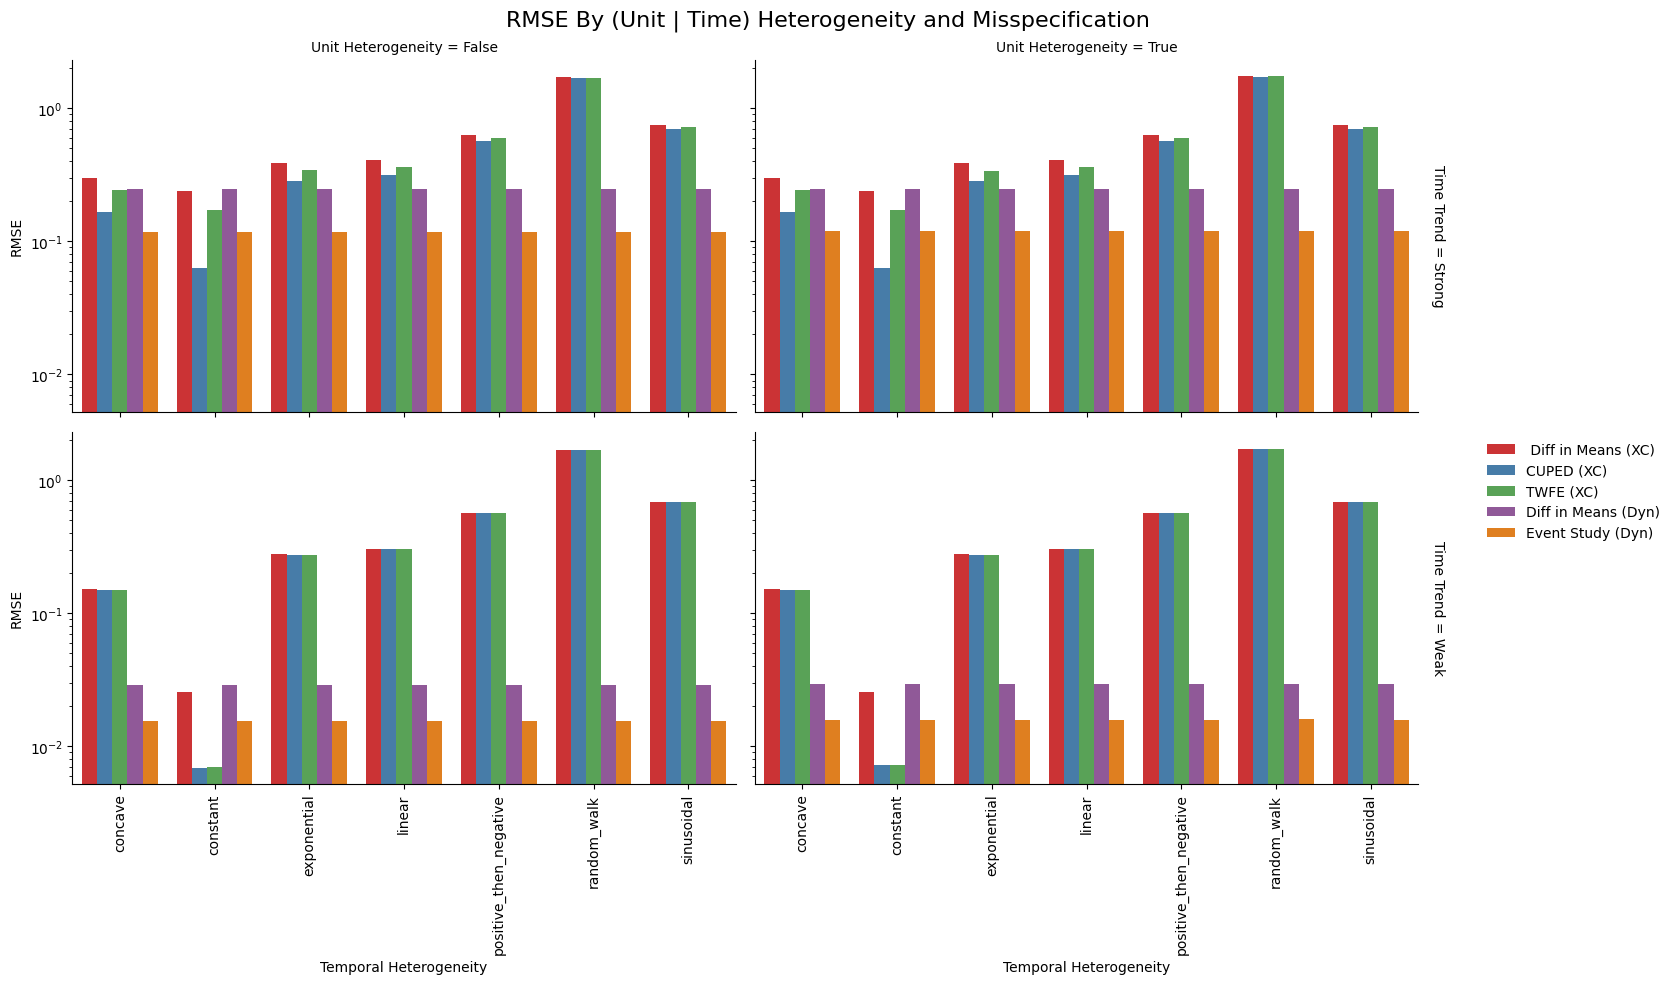

In [9]:
# Create the FacetGrid
g = sns.FacetGrid(
    melted_df,
    col="Unit Heterogeneity",
    row="Time Trend",
    height=5,
    aspect=1.5,
    margin_titles=True,
)
g.map(
    sns.barplot,
    "Temporal Heterogeneity",
    "RMSE",
    "Estimator",
    hue="Estimator",
    palette=sns.color_palette("Set1"),
)

plt.subplots_adjust(top=0.9)
g.fig.suptitle(
    "RMSE By (Unit | Time) Heterogeneity and Misspecification", fontsize=16, y=0.98
)
for ax in g.axes.flat:
    ax.set_yscale("log")
# Rotate and align the tick labels so they look better
for ax in g.axes.flat[2:]:
    # Rotate and align the tick labels so they look better
    print(ax.get_xticklabels())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    # Adjust the subplot to make room for the rotated labels
# Show the plot
plt.tight_layout()
g.add_legend()
plt.show()
g.savefig("../output/rmse_barplot.pdf")